In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json
from os.path import expanduser

#### compare PASEF features that were identified and see whether 3DID also detected them

In [2]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

IDENTS_PASEF_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-04-26-21-16-43/identifications-pasef'.format(expanduser("~"))
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

FEATURES_3DID_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

In [3]:
# load the features detected by PASEF
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_pasef_df = d['identifications_df']
idents_pasef_df = idents_pasef_df[(idents_pasef_df.run_name == run_name)]

In [4]:
# load the features detected by 3DID
with open(FEATURES_3DID_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_df']

In [5]:
print('{} features from PASEF, {} features from 3DID'.format(len(idents_pasef_df), len(features_3did_df)))

55172 features from PASEF, 44783 features from 3DID


In [6]:
idents_pasef_df.charge.value_counts()

2    41080
3     6251
1     4940
4     2090
5      629
6      182
Name: charge, dtype: int64

In [7]:
features_3did_df.charge.value_counts()

2    34159
4     4128
3     3895
1     1468
5     1133
Name: charge, dtype: int64

In [8]:
DUP_MZ_TOLERANCE_PPM = 5
DUP_SCAN_TOLERANCE = 20
DUP_RT_TOLERANCE = 10

In [9]:
# set up dup definitions for 3DID
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
features_3did_df['dup_mz'] = features_3did_df['monoisotopic_mz']  # shorthand to reduce verbosity
features_3did_df['dup_mz_ppm_tolerance'] = features_3did_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
features_3did_df['dup_mz_lower'] = features_3did_df.dup_mz - features_3did_df.dup_mz_ppm_tolerance
features_3did_df['dup_mz_upper'] = features_3did_df.dup_mz + features_3did_df.dup_mz_ppm_tolerance
features_3did_df['dup_scan_lower'] = features_3did_df.scan_apex - DUP_SCAN_TOLERANCE
features_3did_df['dup_scan_upper'] = features_3did_df.scan_apex + DUP_SCAN_TOLERANCE
features_3did_df['dup_rt_lower'] = features_3did_df.rt_apex - DUP_RT_TOLERANCE
features_3did_df['dup_rt_upper'] = features_3did_df.rt_apex + DUP_RT_TOLERANCE

In [10]:
# set up dup definitions for PASEF
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
idents_pasef_df['dup_mz'] = idents_pasef_df['monoisotopic_mz']  # shorthand to reduce verbosity
idents_pasef_df['dup_mz_ppm_tolerance'] = idents_pasef_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
idents_pasef_df['dup_mz_lower'] = idents_pasef_df.dup_mz - idents_pasef_df.dup_mz_ppm_tolerance
idents_pasef_df['dup_mz_upper'] = idents_pasef_df.dup_mz + idents_pasef_df.dup_mz_ppm_tolerance
idents_pasef_df['dup_scan_lower'] = idents_pasef_df.scan_apex - DUP_SCAN_TOLERANCE
idents_pasef_df['dup_scan_upper'] = idents_pasef_df.scan_apex + DUP_SCAN_TOLERANCE
idents_pasef_df['dup_rt_lower'] = idents_pasef_df.rt_apex - DUP_RT_TOLERANCE
idents_pasef_df['dup_rt_upper'] = idents_pasef_df.rt_apex + DUP_RT_TOLERANCE

In [11]:
idents_pasef_df.sort_values(by=['deconvolution_score'], ascending=False, inplace=True)
features_3did_df.sort_values(by=['deconvolution_score'], ascending=False, inplace=True)

In [12]:
# find whether a feature detected by PASEF was also detected by 3DID
common_l = []
for row in idents_pasef_df.itertuples():
#     df = features_3did_df[(row.charge == features_3did_df.charge) & (row.dup_mz >= features_3did_df.dup_mz_lower) & (row.dup_mz <= features_3did_df.dup_mz_upper) & (row.scan_apex >= features_3did_df.dup_scan_lower) & (row.scan_apex <= features_3did_df.dup_scan_upper) & (row.rt_apex >= features_3did_df.dup_rt_lower) & (row.rt_apex <= features_3did_df.dup_rt_upper)].copy()
    df = features_3did_df[(row.dup_mz >= features_3did_df.dup_mz_lower) & (row.dup_mz <= features_3did_df.dup_mz_upper) & (row.scan_apex >= features_3did_df.dup_scan_lower) & (row.scan_apex <= features_3did_df.dup_scan_upper) & (row.rt_apex >= features_3did_df.dup_rt_lower) & (row.rt_apex <= features_3did_df.dup_rt_upper)].copy()
    if len(df) > 0:
        common_l.append(
            {
                'feature_id_pasef':row.feature_id, 
                'deconv_score_pasef':row.deconvolution_score,
                'feature_intensity_pasef':row.feature_intensity,
                'feature_id_3did':df.iloc[0].feature_id, 
                'deconv_score_3did':df.iloc[0].deconvolution_score,
                'feature_intensity_3did':df.iloc[0].feature_intensity
            }
        )
common_df = pd.DataFrame(common_l)

In [13]:
print('{} features in common'.format(len(common_df)))

11398 features in common


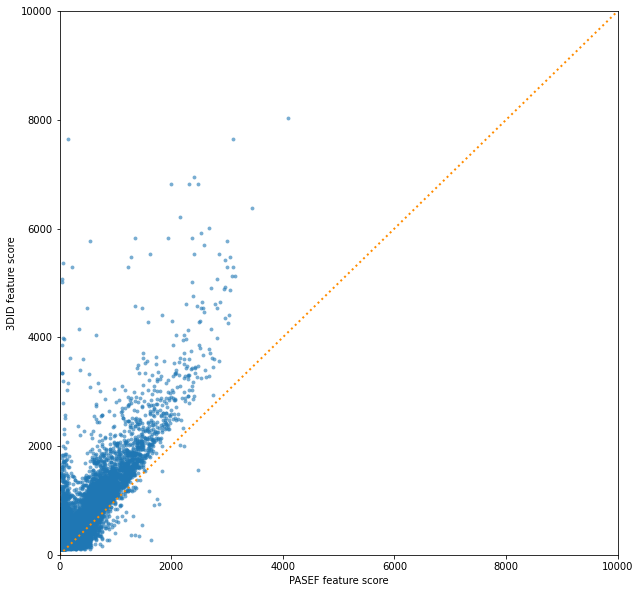

In [14]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('')

ax.scatter(common_df.deconv_score_pasef, common_df.deconv_score_3did, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-1,10000))
plt.ylim((-1,10000))

plt.xlabel('PASEF feature score')
plt.ylabel('3DID feature score')

plt.show()

#### visualise a feature detected by PASEF but not by 3DID

In [15]:
# find the PASEF feature IDs that are not in the common set
feature_ids_not_found_by_3did_l = list(set(idents_pasef_df.feature_id.to_list()) - set(common_df.feature_id_pasef.to_list()))


In [16]:
import random

pasef_feature_not_detected = random.choice(feature_ids_not_found_by_3did_l)
pasef_feature_not_detected

3272105

In [17]:
selected_feature = idents_pasef_df[(idents_pasef_df.feature_id == pasef_feature_not_detected)].iloc[0]
selected_feature

mz_apex_without_saturation_correction                                                      1037.9
mz_apex_with_saturation_correction                                                         1037.9
mz_lower                                                                                  1037.87
mz_upper                                                                                  1037.93
scan_apex                                                                                     308
scan_lower                                                                                    271
scan_upper                                                                                    346
rt_apex                                                                                   2016.69
rt_lower                                                                                  2013.51
rt_upper                                                                                  2019.86
mono_intensity_witho